# EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt"
names = ["year", "month", "day", "year_decimal", "co2", "days", "1 yr ago",
          "10 yr ago", "since 1800"]
maunaloa = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                       names=names, parse_dates=[[0,1,2]], na_values=[-999.99], index_col='year_month_day')
maunaloa.head()

,year_decimal,co2,days,1 yr ago,10 yr ago,since 1800
year_month_day,,,,,,
1974-05-19,1974.3795,333.37,5,NaN,NaN,50.40
1974-05-26,1974.3986,332.95,6,NaN,NaN,50.06
1974-06-02,1974.4178,332.35,5,NaN,NaN,49.60
1974-06-09,1974.4370,332.20,7,NaN,NaN,49.65
1974-06-16,1974.4562,332.37,7,NaN,NaN,50.06


<AxesSubplot:xlabel='year_month_day'>

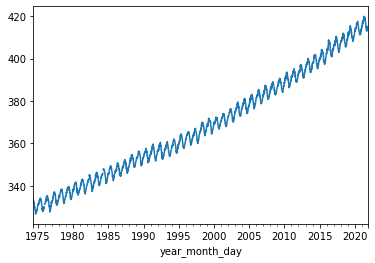

In [5]:
maunaloa.co2.plot()

In [13]:
#checking duplicated rows
maunaloa.duplicated().sum()

0

In [14]:
#checking null values
maunaloa.isna().sum()

year_decimal      0
co2              18
days              0
1 yr ago         70
10 yr ago       541
since 1800       18
dtype: int64

# Modeling

<b>Differences between Time Series and regular Linear Regression</b>  
No iid structure.  Time series doesn't have features and previous steps are the features that're used for modeling.

<b>Process:</b>  
1. Parse the date column and set it to index.  
2. Fill missing data, could use pandas fillna with ffill.  Ffill is fine for time series data, not so much for regular regression models.  
3. Data should have the same frequency or be equally spaced.  Resample with pandas resample.  
4. Make sure time series is Stationary.  De-trend data if neccessary (see comments below).

Text(0, 0.5, 'CO2 Measurements')

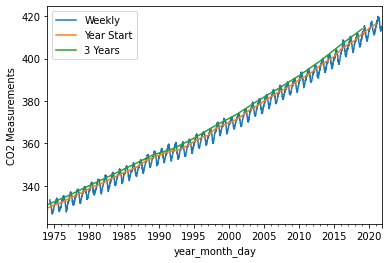

In [20]:
#for time series it's fine to fill with value prior to missing record
maunaloa.fillna(method='ffill', inplace=True)
#need to set periods to the same frequency, will resample for each month with average
maunaloa.co2.resample('W').mean().plot(label='Weekly')
maunaloa.co2.resample('AS').mean().plot(label='Year Start')
maunaloa.co2.resample('3AS').mean().plot(label='3 Years')
plt.legend()
plt.ylabel('CO2 Measurements')

<b>Ideally a time series should be Stationary.  Below is the requirements for stationary time series:</b>  
1. Mean independent of time. 
2. Variance independent of time.  
3. Covariance of 2 observations k steps apart are independent of time (Autocorrelation).    

From plot above, we can see that mean changes over time therefore it's not a stationary time series.  Need to detrend it, or make it stationary.

In [23]:
#checking for autocorrelation
weekly = maunaloa.co2.autocorr()
week_26 = maunaloa.co2.autocorr(lag=26)
week_52 = maunaloa.co2.autocorr(lag=52)
print(f'Weekly Autocorrelation: {weekly:.3f}')
print(f'26 Weeks Autocorrelation: {week_26:.3f}')
print(f'52 Weeks Autocorrelation: {week_52:.3f}')

Weekly Autocorrelation: 1.000
26 Weeks Autocorrelation: 0.985
52 Weeks Autocorrelation: 1.000


Extremely high autocorrelation for weekly and yearly steps.  Some decrease in half a year step.  
Checking for autocorrelation for different lags

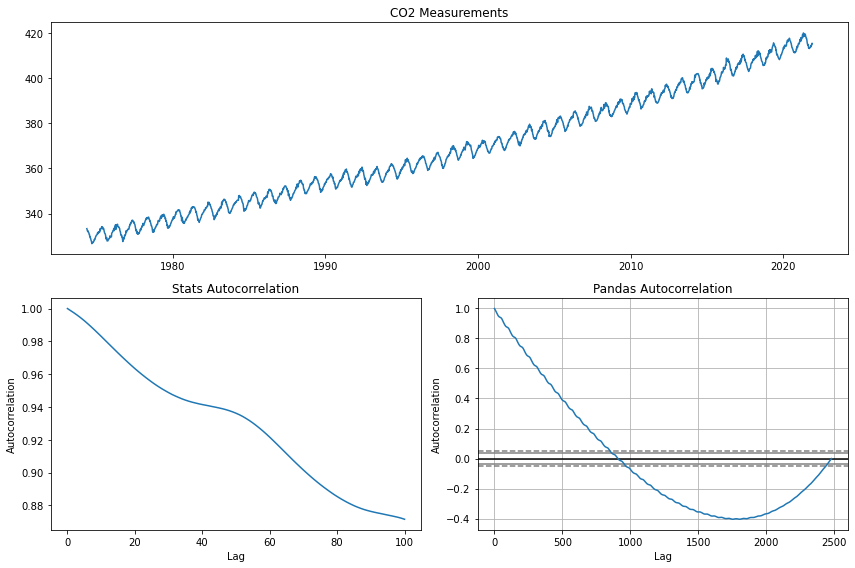

In [52]:
#plotting autocorrelation with stattools
from statsmodels.tsa.stattools import acf
from pandas.plotting import autocorrelation_plot


fig = plt.figure(figsize=(12, 8))
ax_data = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,2,3)
ax2 = fig.add_subplot(2,2,4)

co2 = maunaloa.co2
ax_data.plot(co2)
ax_data.set_title('CO2 Measurements')

autocorr = acf(co2, nlags=100)
ax1.plot(autocorr)
ax1.set_ylabel('Autocorrelation')
ax1.set_xlabel('Lag')
ax1.set_title('Stats Autocorrelation')

#can also plot with pandas
autocorrelation_plot(co2, ax=ax2)
ax2.set_title('Pandas Autocorrelation')

fig.tight_layout()

52 weeks is showing a flattening for autocorrelation, suggests high correlation between steps 52 weeks apart (year).  

Both ways of plotting autocorrelation are sufficient to determine the trends.  
Pandas plots confidence intervals with grey lines 95% with solid grey and 99% with dashed grey line.  

Can de-trend by taking differences between rows, so modeling changes for each time step. Also possible to model trend explicitly

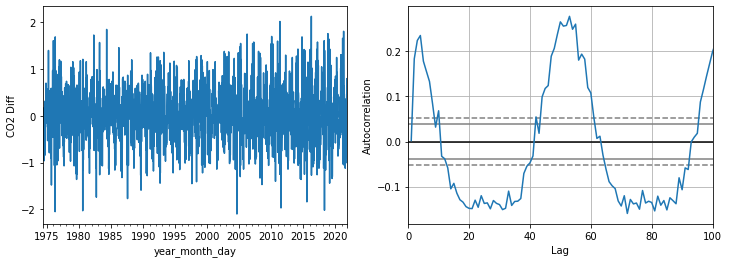

In [59]:
#first method is to take differences between measurements
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
diff = co2.diff()
diff.plot(ax=ax1)
ax1.set_ylabel('CO2 Diff')

#need to select everything after the first row because it's NAN
autocorrelation_plot(diff[1:], ax=ax2)
ax2.set_xlim(0, 100)
plt.show()

<b>Take-aways:</b>  
1. It's evident that there is less autocorrelation, but still present within the data. Periodicity becomes more obvious.   
2. Mean however isn't changing, that's evident from the left plot.  
3. Peak at 52 weeks is more evident now as well.  

## Autoregressive (linear) model

Model takes k previous steps as features and builds a linear model with coefficients and offset to predict the next time step.  

Don't always need to de-trend the data, sometimes model can capture seasonality.

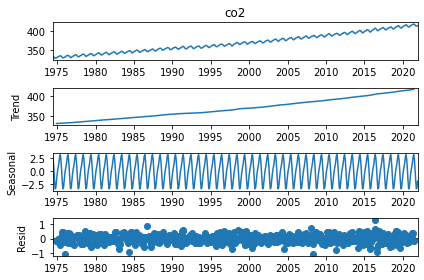

In [124]:
#can breakdown everything on to trend and seasonal component with statsmodel
from statsmodels.tsa.seasonal import seasonal_decompose

#converting data to monthly and taking average monthly measurements
co2 = co2.resample('M').mean()
decomposition = seasonal_decompose(co2, model='additive')
fig = decomposition.plot()

First plot is the raw data. 
Second is the moving average.  
Third is seasonal component.  
Fourth are the residials.  

The information displayed above is mainly for inference.  

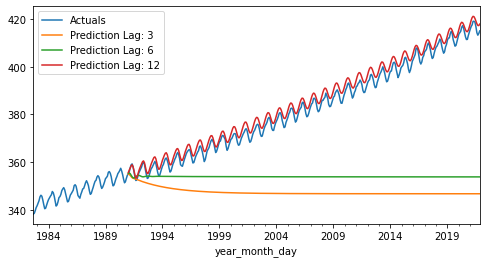

In [129]:
from statsmodels.tsa import ar_model

fig, ax = plt.subplots(figsize=(8,4))
co2[100:].plot(label='Actuals', ax=ax)

#lags determines how many previous points to include for prediction
for lag in [3, 6, 12]:
    #passing first 200 rows for training
    ar = ar_model.AutoReg(co2[:200], lags=lag)
    #return fitted model
    res = ar.fit()
    res.predict(co2.index[200], co2.index[-1]).plot(label=f'Prediction Lag: {lag}', ax=ax)

ax.legend()
plt.show()

In [130]:
#printing coefs
res.params

const     -1.486085
co2.L1     0.733271
co2.L2    -0.170889
co2.L3    -0.117395
co2.L4    -0.075936
co2.L5     0.205013
co2.L6    -0.054012
co2.L7     0.003535
co2.L8    -0.169395
co2.L9     0.177846
co2.L10   -0.022077
co2.L11    0.247795
co2.L12    0.248893
dtype: float64

<b>Take-aways:</b>  
1. Picking lag is important for autoregressive models.  Lag should be at least long enough to capture seasonality.  
2. From plot above it's evident that 3 and 6 months don't capture seasonality, therefore not matching well.  
3. 12 months capture seasonality, but since it's using previous points to predict the future it starts to diverge in the far away predictions.

## Sklearn 1D model

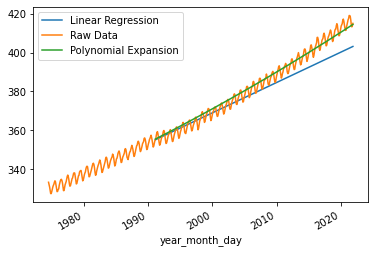

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#setting target
rows = 200
train = co2[:rows]
test = co2[rows:]
#need to convert to ordinal instead of dates
X = co2.index.to_series().apply(lambda x: x.toordinal())
X = pd.DataFrame(X)
#train test split
X_train, X_test = X.iloc[:rows,:], X.iloc[rows:, :]

#Linear Regression
lr = LinearRegression().fit(X_train, train)
lr_pred = lr.predict(X_test)
plt.plot(co2.index[rows:], lr_pred, label='Linear Regression')
co2.plot(label='Raw Data')

#polynomial regression
lr_poly = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())
lr_poly.fit(X_train, train)
plt.plot(co2.index[rows:], lr_poly.predict(X_test), label='Polynomial Expansion')
plt.legend()

Doesn't fit averages as well since it's just a linear relationship.  
Polynomial expansion is much better.  

<b>Linear model will model average line, need to introduce additional features to model seasonality, such as months</b>

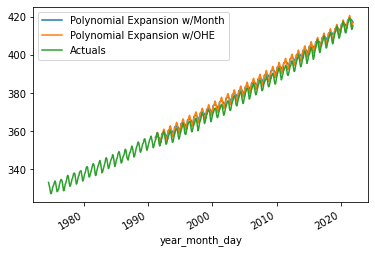

In [188]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

X['month'] = X.index.month
X_train, X_test = X.iloc[:rows,:], X.iloc[rows:, :]

lr_poly.fit(X_train, train)

ohe = make_column_transformer((OneHotEncoder(sparse=False), ['month']), remainder='passthrough')
lr_poly_ohe = make_pipeline(ohe, 
                            PolynomialFeatures(include_bias=False),
                            LinearRegression())
lr_poly_ohe.fit(X_train, train)

plt.plot(co2.index[rows:], lr_poly.predict(X_test), label='Polynomial Expansion w/Month')
plt.plot(co2.index[rows:], lr_poly_ohe.predict(X_test), label='Polynomial Expansion w/OHE')
co2.plot(label='Actuals')

plt.legend()

Linear regression on years will model trend with CO2 measurements.  Introduction of month feature captures seasonality.  Seasonality can be either modeled with OHE or regular linear regression as well.